In [1]:
# Needed on Google Colab
import os
if os.environ.get('COLAB_GPU', False):
    !pip install -U transformers
    from google.colab import drive
    drive.mount("/content/drive")

     |████████████████████████████████| 2.2MB 6.8MB/s 
     |████████████████████████████████| 870kB 37.6MB/s 
     |████████████████████████████████| 3.3MB 41.7MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.44-cp37-none-any.whl size=886084 sha256=0030802229501c484d78dcb2a7bcf0ad4e350cf3bd2f76c5df6ec97d181222de
  Stored in directory: /root/.cache/pip/wheels/3e/fb/c0/13ab4d63d537658f448366744654323077c4d90069b6512f3c
Successfully built sacremoses
Mounted at /content/drive


In [2]:
import nltk
import re
import pickle
import pandas as pd
import numpy as np
import seaborn as sns
import tensorflow as tf
from datetime import datetime
from sklearn import metrics
from sklearn.model_selection import train_test_split
from nltk.stem.snowball import SnowballStemmer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import warnings

pd.options.display.max_colwidth = 6000
pd.options.display.max_rows = 400
np.set_printoptions(suppress=True)
warnings.filterwarnings("ignore")
print(tf.__version__)

2.4.1


Executing this on Colab will make sure that our model runs on a TPU if available and falls back to GPU / CPU otherwise:

In [3]:
# Try to run on TPU if available
# Detect hardware, return appropriate distribution strategy
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection
    print("Running on TPU ", tpu.cluster_spec().as_dict()["worker"])
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    strategy = tf.distribute.get_strategy()
print("REPLICAS: ", strategy.num_replicas_in_sync)

Running on TPU  ['10.72.29.226:8470']
INFO:tensorflow:Initializing the TPU system: grpc://10.72.29.226:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.72.29.226:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


REPLICAS:  8


In our case, we are running on a TPU with eight cores. This will give us an immense speed up!  
As before, we first download and extract our data:

In [4]:
# store current path and download and extract data there
CURR_PATH = !pwd

In [5]:
# PARAMETERS
PATH_DATA = CURR_PATH[0]
PATH_GDRIVE_TMP = "/content/drive/MyDrive/tmp/"  # Google Drive

Let's load the data set and create our target variable. Positive ratings (one or two) will be considered as good and negative ones (five or six) as negative. As before, we ignore neutral ratings:

In [6]:
# read data from csv
data = pd.read_csv(PATH_GDRIVE_TMP + "only_lockdown.csv", sep='\t', header=None, skiprows=[0])

# Create binary grade, class 1-2 or 5-6  = good or bad
data["opinion_integer"] = 0
data.loc[data[6] == '-', "opinion_integer"] = 0
data.loc[data[6] == 'o', "opinion_integer"] = 1
data.loc[data[6] == '+', "opinion_integer"] = 2

data.head(6)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,opinion_integer
0,-,x,x,x,-,-,-,29137,2020_03_15,16,NEOS,Abgeordneter Josef Schellhorn (NEOS),False,"Das heißt, diese Planbarkeit ist jetzt gar nicht machbar – für Sie nicht –, nur die Unternehmer kommen mit dieser Unplanbarkeit gar nicht zurecht, weil dieser Lockdown ja jetzt nur für eine Woche bestimmt ist.",0
1,-,x,-,x,x,-,-,31054,2020_03_20,19,NEOS,"Abgeordnete Mag. Beate Meinl-Reisinger, MES (NEOS)",False,"Wie und wann schaffen wir es, aus diesem Lockdown wieder herauszukommen, ohne die Gesundheit der Menschen in Österreich oder auch europaweit aufs Spiel zu setzen?",0
2,-,#,#+,-,x,-,-,32973,2020_04_03,22,ÖVP,Abgeordneter August Wöginger (ÖVP),True,"Kickl hat am 13. März von einem Lockdown gesprochen – also alles zudrehen, nichts geht mehr in diesem Land.",0
3,+,x,+,x,x,+,+,34265,2020_04_03,22,NEOS,Abgeordnete Dipl.-Ing. Karin Doppelbauer (NEOS),False,"Ich möchte gleich zu Beginn eines klarstellen, damit es keine Missverständnisse gibt: Ja, der Lockdown war richtig.",2
4,+,x,x,x,o,o,-,34269,2020_04_03,22,NEOS,Abgeordnete Dipl.-Ing. Karin Doppelbauer (NEOS),False,"Lassen Sie mich aber mit dem Gemeinsamen beginnen: Was das Ziel betrifft, sind wir uns ja alle einig: Es geht um nichts Geringeres als das Einpendeln unserer Volks­wirtschaft auf ein Level, wie es vor der Krise war, oder, wenn Sie so wollen, wenn man jetzt den Lockdown schrittweise lockert, dass dann das Wirtschaftssystem eigentlich genauso aussieht, wie es vor der Krise war.",0
5,+,x,x,x,+s,o,o,34709,2020_04_03,22,NEOS,Abgeordnete Mag. Martina Künsberg Sarre (NEOS),False,"Regelmäßige begleitende Datenerhe­bun­gen in dieser Phase des Lockdowns, in der Lehrer_innen, Schüler_innen und Eltern auf digitales Unterrichten und Lernen absolut angewiesen sind, können einen wesent­lichen Beitrag für eine effiziente Digitalisierung des Bildungssystems in der Zukunft leisten.",1


In [7]:
nltk.download("stopwords")
nltk.download("punkt")
stemmer = SnowballStemmer("german")
stop_words = set(stopwords.words("german"))


def clean_text(text, for_embedding=False):
    """
        - remove any html tags (< /br> often found)
        - Keep only ASCII + European Chars and whitespace, no digits
        - remove single letter chars
        - convert all whitespaces (tabs etc.) to single wspace
        if not for embedding (but e.g. tdf-idf):
        - all lowercase
        - remove stopwords, punctuation and stemm
    """
    RE_WSPACE = re.compile(r"\s+", re.IGNORECASE)
    RE_TAGS = re.compile(r"<[^>]+>")
    RE_ASCII = re.compile(r"[^A-Za-zÀ-ž ]", re.IGNORECASE)
    RE_SINGLECHAR = re.compile(r"\b[A-Za-zÀ-ž]\b", re.IGNORECASE)
    if for_embedding:
        # Keep punctuation
        RE_ASCII = re.compile(r"[^A-Za-zÀ-ž,.!? ]", re.IGNORECASE)
        RE_SINGLECHAR = re.compile(r"\b[A-Za-zÀ-ž,.!?]\b", re.IGNORECASE)

    text = re.sub(RE_TAGS, " ", text)
    text = re.sub(RE_ASCII, " ", text)
    text = re.sub(RE_SINGLECHAR, " ", text)
    text = re.sub(RE_WSPACE, " ", text)

    word_tokens = word_tokenize(text)
    words_tokens_lower = [word.lower() for word in word_tokens]

    if for_embedding:
        # no stemming, lowering and punctuation / stop words removal
        words_filtered = word_tokens
    else:
        words_filtered = [
            stemmer.stem(word) for word in words_tokens_lower if word not in stop_words
        ]

    text_clean = " ".join(words_filtered)
    return text_clean

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


Now, we can we apply this pre-processing and cleaning to our original data:

In [8]:
%%time
# Clean Comments
data["comment_clean"] = data.loc[data[13].str.len() > 20, 13]
data["comment_clean"] = data["comment_clean"].map(
    lambda x: clean_text(x, for_embedding=True) if isinstance(x, str) else x
)

CPU times: user 158 ms, sys: 4.54 ms, total: 162 ms
Wall time: 174 ms


This is how the final comments will look like:

In [9]:
data['totalwords'] = data['comment_clean'].str.count(' ') + 1

In [10]:
data['totalwords'].max()

121

In [11]:
# Drop Missing
data = data.dropna(axis="index", subset=["opinion_integer", "comment_clean"]).reset_index(
    drop=True
)
data = data[["comment_clean", "opinion_integer"]]
data.columns = ["text", "label"]
data.head(2)
data.to_csv(PATH_GDRIVE_TMP + "only_lockdown_pp.csv", index=False)

In [12]:
# skip pre processing if done before
#data = pd.read_csv(PATH_GDRIVE_TMP + "only_lockdown_pp.csv")

In [13]:
# this will download and initialize the pre trained tokenizer
from transformers import BertTokenizer, TFBertModel

tokenizer = BertTokenizer.from_pretrained("bert-base-german-cased")

In [14]:
MAXLEN = 128
#MAXLEN = 256

def preprocess_text(data):
    """ take texts and prepare as input features for BERT 
    """
    input_ids = []
    # For every sentence...
    for comment in data:
        encoded_sent = tokenizer.encode_plus(
            text=comment,
            add_special_tokens=True,  # Add `[CLS]` and `[SEP]`
            max_length=MAXLEN,  # Max length to truncate/pad
            pad_to_max_length=True,  # Pad sentence to max length
            return_attention_mask=False,  # attention mask not needed for our task
        )
        # Add the outputs to the lists
        input_ids.append(encoded_sent.get("input_ids"))
    return input_ids

Before creating our features, let's check out the workings of the tokenizer with an example:

In [15]:
# Original Comment and encoding outputs
comment = ["Bedingt durch die Maßnahmen der ÖVP Grüne Bundesregierung, insbesondere der neuerliche Lockdown im November lassen die Einnahmen ganzer Branchen wegbrechen."]
input_ids = preprocess_text(comment)
print("Comment: ", comment)
print("Tokenized Comment: ", tokenizer.convert_ids_to_tokens(input_ids[0])[0:20])
print("Token IDs: ", input_ids[0][0:20])

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


Comment:  ['Bedingt durch die Maßnahmen der ÖVP Grüne Bundesregierung, insbesondere der neuerliche Lockdown im November lassen die Einnahmen ganzer Branchen wegbrechen.']
Tokenized Comment:  ['[CLS]', 'Beding', '##t', 'durch', 'die', 'Maßnahmen', 'der', 'ÖVP', 'Grüne', 'Bundesregierung', ',', 'insbesondere', 'der', 'neuer', '##liche', 'Lock', '##down', 'im', 'November', 'lassen']
Token IDs:  [3, 14560, 26901, 261, 30, 3406, 21, 26318, 14134, 4260, 26918, 1831, 21, 4201, 322, 22158, 21646, 106, 1324, 1641]


In [16]:
%%time
import pickle

input_ids = preprocess_text(data["text"])
# tokenization takes quite long
# we can save the result and load it quickly via pickle
pickle.dump(input_ids, open(PATH_GDRIVE_TMP + "input_ids_lockdown.pkl", "wb"))
# input_ids = pickle.load(open(PATH_GDRIVE_TMP+"/input_ids.pkl", "rb"))

CPU times: user 450 ms, sys: 0 ns, total: 450 ms
Wall time: 628 ms


In [17]:
# Sample data for cross validation
train_ids, test_ids, train_labels, test_labels = train_test_split(
    input_ids, data["label"], test_size=0.15, shuffle=True, stratify=data["label"]
)
print(f"Train set: {len(train_ids)}\nTest set: {len(test_ids)}")

Train set: 418
Test set: 74


In [18]:
strategy.num_replicas_in_sync

8

In [19]:
# Set Model Parameters
MAXLEN = MAXLEN
BATCH_SIZE_PER_REPLICA = 8
BATCH_SIZE = BATCH_SIZE_PER_REPLICA * strategy.num_replicas_in_sync
EPOCHS = 20
LEARNING_RATE = 1e-5
DATA_LENGTH = len(data)

In [20]:
def create_dataset(
    data_tuple,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    buffer_size=DATA_LENGTH,
    train=False,
):
    dataset = tf.data.Dataset.from_tensor_slices(data_tuple)
    if train:
        dataset = dataset.shuffle(
            buffer_size=buffer_size, reshuffle_each_iteration=True
        ).repeat(epochs)
    dataset = dataset.batch(batch_size)
    return dataset


train = create_dataset(
    (train_ids, train_labels), buffer_size=len(train_ids), train=True, 
)
test = create_dataset((test_ids, test_labels), buffer_size=len(test_ids))

Finally, we define a function that returns our model architecture:

In [21]:
def build_model(transformer, max_len=MAXLEN):
    """ add binary classification to pretrained model
    """
    input_word_ids = tf.keras.layers.Input(
        shape=(max_len,), dtype=tf.int32, name="input_word_ids"
    )
    sequence_output = transformer(input_word_ids)[0]
    cls_token = sequence_output[:, 0, :]
    out = tf.keras.layers.Dense(3, activation="sigmoid")(cls_token)
    model = tf.keras.models.Model(inputs=input_word_ids, outputs=out)
    model.compile(
        tf.keras.optimizers.Adam(lr=LEARNING_RATE),
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"],
    )
    return model

In the first step, we define an `Input` layer which expects our numeric vectors as input. Then, we add the pre trained transformer which receives the inputs from the previous layer. The output of the transformer is then fed into a `Dense` layer which finally outputs a probability for our input belonging to class 0 or 1.  
Now, we build our model by first downloading the pre trained BERT and passing it to our `build_model` function:

In [22]:
with strategy.scope():
    transformer_layers = TFBertModel.from_pretrained("bert-base-german-cased")
    model = build_model(transformer_layers, max_len=MAXLEN)
model.summary()

Some layers from the model checkpoint at bert-base-german-cased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-german-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: while/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: while/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: while/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_word_ids (InputLayer)  [(None, 128)]             0         
_________________________________________________________________
tf_bert_model (TFBertModel)  TFBaseModelOutputWithPool 109081344 
_________________________________________________________________
tf.__operators__.getitem (Sl (None, 768)               0         
_________________________________________________________________
dense (Dense)                (None, 3)                 2307      
Total params: 109,083,651
Trainable params: 109,083,651
Non-trainable params: 0
_________________________________________________________________


In [23]:
# Stop training when validation acc starts dropping
# Save checkpoint of model each period
now = datetime.now().strftime("%Y-%m-%d_%H%M")
# Create callbacks
callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor="val_loss", verbose=1, patience=EPOCHS, restore_best_weights=True
    ),
    # tf.keras.callbacks.ModelCheckpoint(
    #    PATH_GDRIVE_TMP + now + "_Model_{epoch:02d}_{val_loss:.4f}.h5",
    #    monitor="val_loss",
    #    save_best_only=True,
    #    verbose=1,
    # ),
]

In [24]:
# Calculate class weights
from collections import Counter
print(Counter(train_labels))
print(Counter(test_labels))
train_counts = Counter(train_labels)
num_in_largest_class = max(train_counts.values())
print(num_in_largest_class)
class_weights = {k: num_in_largest_class / train_counts[k] for k in train_counts.keys()}
print(class_weights)

Counter({0: 235, 1: 107, 2: 76})
Counter({0: 41, 1: 19, 2: 14})
235
{0: 1.0, 2: 3.0921052631578947, 1: 2.196261682242991}


In [25]:
%%time
# Train using appropriate steps per epochs (go through all train data in an epoch)
steps_per_epoch = int(np.floor((len(train_ids) / BATCH_SIZE)))
print(
    f"Model Params:\nbatch_size: {BATCH_SIZE}\nEpochs: {EPOCHS}\n"
    f"Step p. Epoch: {steps_per_epoch}\n"
    f"Learning rate: {LEARNING_RATE}"
)
hist = model.fit(
    train,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    steps_per_epoch=steps_per_epoch,
    validation_data=test,
    verbose=1,
    class_weight = class_weights,
    callbacks=callbacks,
)

Model Params:
batch_size: 64
Epochs: 20
Step p. Epoch: 6
Learning rate: 1e-05
Epoch 1/20


6/6 [==============================] - ETA: 0s - loss: 2.3072 - accuracy: 0.3358WARNING:tensorflow:The parameters `output_attentions`, `output_hidden_states` and `use_cache` cannot be updated when calling a model.They have to be set to True/False in the config object (i.e.: `config=XConfig.from_pretrained('name', output_attentions=True)`).


6/6 [==============================] - 85s 3s/step - loss: 2.3117 - accuracy: 0.3403 - val_loss: 0.9966 - val_accuracy: 0.5270
Epoch 2/20
6/6 [==============================] - 1s 257ms/step - loss: 1.8110 - accuracy: 0.4013 - val_loss: 1.1081 - val_accuracy: 0.3919
Epoch 3/20
6/6 [==============================] - 1s 259ms/step - loss: 1.9074 - accuracy: 0.4011 - val_loss: 1.1014 - val_accuracy: 0.2432
Epoch 4/20
6/6 [==============================] - 2s 338ms/step - loss: 1.7639 - accuracy: 0.3300 - val_loss: 1.0686 - val_accuracy: 0.3919
Epoch 5/20
6/6 [==============================] - 1s 258ms/step - loss: 1.7737 - accuracy: 0.3988 - val_loss: 1.1091 - val_accuracy: 0.3108
Epoch 6/20
6/6 [==============================] - 1s 258ms/step - loss: 1.7301 - accuracy: 0.3932 - val_loss: 1.0432 - val_accuracy: 0.3919
Epoch 7/20
6/6 [==============================] - 1s 255ms/step - loss: 1.7451 - accuracy: 0.4208 - val_loss: 1.1168 - val_accuracy: 0.3378
Epoch 8/20
6/6 [=================

The model converges really fast and stops early after only three epochs. This is because it already achieves the lowest validation loss in the second period:

[Text(0, 0.5, ''),
 [Text(0, 0, '1'),
  Text(0, 0, '2'),
  Text(0, 0, '3'),
  Text(0, 0, '4'),
  Text(0, 0, '5'),
  Text(0, 0, '6'),
  Text(0, 0, '7'),
  Text(0, 0, '8'),
  Text(0, 0, '9'),
  Text(0, 0, '10'),
  Text(0, 0, '11'),
  Text(0, 0, '12'),
  Text(0, 0, '13'),
  Text(0, 0, '14'),
  Text(0, 0, '15'),
  Text(0, 0, '16'),
  Text(0, 0, '17'),
  Text(0, 0, '18'),
  Text(0, 0, '19'),
  Text(0, 0, '20')],
 Text(0.5, 1.0, 'Model loss')]

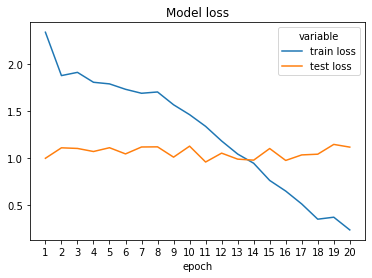

In [26]:
loss = pd.DataFrame(
    {"train loss": hist.history["loss"], "test loss": hist.history["val_loss"]}
).melt()
loss["epoch"] = loss.groupby("variable").cumcount() + 1
sns.lineplot(x="epoch", y="value", hue="variable", data=loss).set(
    title="Model loss",
    ylabel="",
    xticks=range(1, loss["epoch"].max() + 1),
    xticklabels=loss["epoch"].unique(),
)

In [27]:
# predict on test set
pred = model.predict(test, batch_size=BATCH_SIZE, verbose=2, use_multiprocessing=True)

2/2 - 12s


In [28]:
np.argmax(pred, axis=-1)

array([0, 0, 0, 1, 0, 0, 1, 2, 1, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 2, 0, 0, 0, 0, 0, 1, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 2, 0, 1, 0, 0, 0, 0, 1, 2, 2, 2, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0])

In [35]:
# Load best model from Checkpoint
# model = load_model(PATH_GDRIVE_TMP+"BERT.h5", compile=False)
pred_class = np.argmax(pred, axis=-1)
report = metrics.classification_report(test_labels, pred_class, output_dict=True)
print(report)

{'0': {'precision': 0.6491228070175439, 'recall': 0.9024390243902439, 'f1-score': 0.7551020408163265, 'support': 41}, '1': {'precision': 0.6, 'recall': 0.3157894736842105, 'f1-score': 0.41379310344827586, 'support': 19}, '2': {'precision': 0.2857142857142857, 'recall': 0.14285714285714285, 'f1-score': 0.19047619047619047, 'support': 14}, 'accuracy': 0.6081081081081081, 'macro avg': {'precision': 0.5116123642439431, 'recall': 0.4536952136438657, 'f1-score': 0.4531237782469309, 'support': 74}, 'weighted avg': {'precision': 0.5677572309151256, 'recall': 0.6081081081081081, 'f1-score': 0.560647558184504, 'support': 74}}


In [36]:
report['accuracy']

0.6081081081081081

In [30]:
# calculate accuracy
correct = pred_class == test_labels
print("Accuracy: " + str(correct.sum() / len(correct)))

Accuracy: 0.6081081081081081
